# Setup
## Imports

In [1]:
%load_ext autoreload
%autoreload 2


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import scipy
from gen_social_choice.utils.helper_functions import get_base_dir_path


## Constants

In [20]:
likert_scores: dict[int, str] = {
    0: "Very poorly",
    1: "Poorly",
    2: "Moderately",
    3: "Well",
    4: "Very well",
    5: "Excellently",
    6: "Exceptionally",
}
likert_scores_reverse: dict[str, int] = {v: k for k, v in likert_scores.items()}


## Load data

In [12]:
data_dir_path = get_base_dir_path() / "data" / "demo_data"
trial_prefix = "TEST_"
assignments_file_path = data_dir_path / f"{trial_prefix}assignments.json"

with open(assignments_file_path, "r") as f:
    assignment_data = (json.load(f))


assignment_data.keys()


dict_keys(['slate', 'slate_statements', 'agent_ids', 'assignments', 'utilities'])

In [15]:
# Create DataFrame with assignments and utilities
assignments = pd.DataFrame({
    'candidate_id': assignment_data['assignments'],
    'utility': assignment_data['utilities']
}, index=assignment_data['agent_ids'])
assignments


,candidate_id,utility
generation84,s9,3.616312
generation42,s16,3.454556
generation1,s9,3.941810
generation5,s9,3.985933
generation67,s9,3.975074
generation38,s9,3.844999
generation78,s16,3.803659
generation66,s9,3.976265
generation72,s1,4.000000
generation99,s9,3.490828


# Plots

## Trial-only plots


ValueError: 'yerr' (shape: (2,)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'y' (shape: (1,))

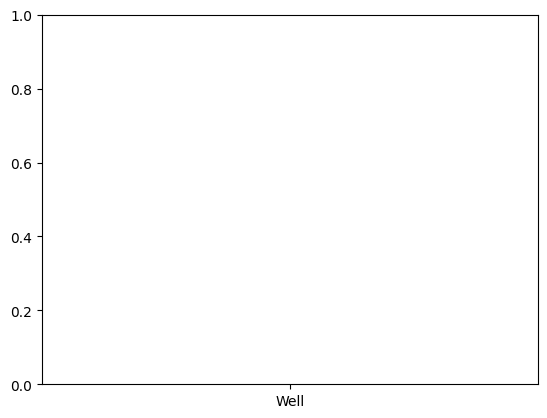

In [24]:
def plot_likert_category_bar_chart(assignments: pd.DataFrame) -> plt.figure:
    """
    Bar chart of the distribution of likert scores with error bars.

    Utilities are rounded to the nearest integer and mapped to the likert scale.
    Bars are sequenced from lowest to highest likert score.
    The y axis is the percentage of the sample that received each score.
    Error bars represent the standard error of the proportion.
    """
    # Round utilities and map to likert scores
    assignments["utility"] = assignments["utility"].round().astype(int)
    assignments["likert_score"] = assignments["utility"].map(likert_scores)
    
    # Calculate counts
    total = len(assignments)
    counts = assignments["likert_score"].value_counts().sort_index()
    
    # Calculate confidence intervals
    def calculate_proportion_confidence_intervals(counts: np.ndarray, total: int) -> np.ndarray:
        proportions = counts / total
        nqp = counts * proportions
        standard_errors = np.sqrt(proportions * (1 - proportions) / total)
        
        # Initialize bounds with normal approximation
        lower_bounds = np.maximum(0, proportions - standard_errors)
        upper_bounds = np.minimum(1, proportions + standard_errors)
        
        # Identify indices where exact calculation is needed
        exact_indices = nqp < 5
        
        # Exact binomial calculation for nqp < 5
        if np.any(exact_indices):
            exact_lower = scipy.stats.binom.ppf(0.025, total, proportions[exact_indices]) / total
            exact_upper = scipy.stats.binom.ppf(0.975, total, proportions[exact_indices]) / total
            lower_bounds[exact_indices] = exact_lower
            upper_bounds[exact_indices] = exact_upper
        
        return np.vstack((lower_bounds, proportions, upper_bounds)).T

    confidence_intervals = calculate_proportion_confidence_intervals(counts.values, total)
    
    # Create DataFrame for plotting
    plot_data = pd.DataFrame({
        "likert_score": counts.index,
        "proportion": confidence_intervals[:, 1],
        "lower_bound": confidence_intervals[:, 0],
        "upper_bound": confidence_intervals[:, 2]
    }).sort_values("likert_score")
    
    # Convert proportions to percentages for plotting
    plot_data["percentage"] = plot_data["proportion"] * 100
    plot_data["lower_bound_percentage"] = plot_data["lower_bound"] * 100
    plot_data["upper_bound_percentage"] = plot_data["upper_bound"] * 100
    
    # Create bar plot with error bars
    plot = sns.barplot(
        data=plot_data,
        x="likert_score",
        y="percentage",
        yerr=[plot_data["percentage"] - plot_data["lower_bound_percentage"], 
              plot_data["upper_bound_percentage"] - plot_data["percentage"]],
        order=sorted(assignments["likert_score"].unique(), key=lambda x: likert_scores_reverse[x])
    )
    
    plot.set(ylabel="Percentage of Population (%)")
    return plot

plot_likert_category_bar_chart(assignments)

## Trial vs Baseline Plots